In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_y_exp
from bo_functions import create_y_data
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_ei_basic
from bo_functions import eval_GP_basic_tot
from bo_functions import create_sse_data

from bo_plotters import plot_hyperparams
from bo_plotters import plot_xy
from bo_plotters import y_plotter
from bo_plotters import stdev_plotter
from bo_plotters import ei_plotter

In [2]:
#Pull x data from CSV
Theta_True = np.array([1,-1])
noise_std = 0.1**2
q = 2

exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)
# print(x)

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])
# print(train_sse)

In [4]:
#Reduce Number of Training Points
t =len(train_T) #Desired number of training points
# t = 10 #Set t=5 to show changing EI
train_T = train_T[0:t]
train_sse = train_sse[0:t]

In [5]:
#Define GP Testing space
#Define Testing Space
p=10
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(theta_mesh)

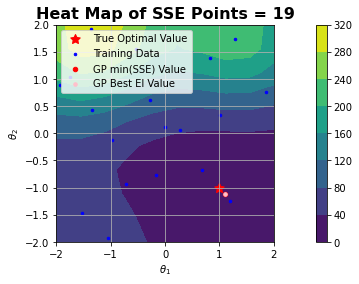

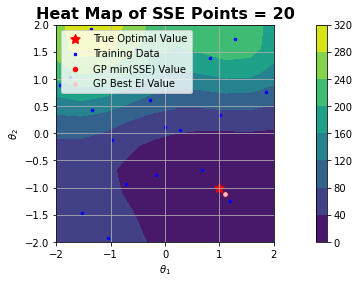

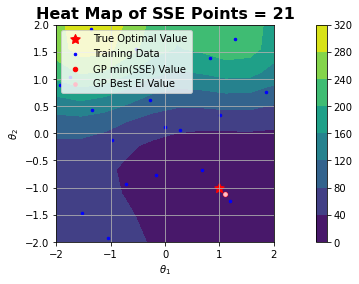

In [6]:
#Training the GP Model
iterations = 300

BO_iter = 3

train_T_dict = {}
train_sse_dict = {}
ei_dict = {}
sse_dict ={}
GP_mean_best_dict = {}
GP_var_best_dict = {}
GP_mean_min_dict ={}
GP_var_min_dict = {}
Theta_Opt_dict = {}
Theta_Best_dict = {}

for i in range(BO_iter):
    if torch.is_tensor(train_T) != True:
        train_T = torch.from_numpy(train_T)
    if torch.is_tensor(train_sse) != True:
        train_sse = torch.from_numpy(train_sse)
    
    train_T_dict[i+1] = train_T
    train_sse_dict[i+1] = train_sse
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse, likelihood)
    train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
    
    ##Set Hyperparameters to 1
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([0.1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale

    
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    #Same point keeps being selected, should I remove that point by force?
    ei_components = eval_GP_basic_tot(p,theta_mesh, train_sse, model, likelihood)
    ei = ei_components[0]
    sse = ei_components[1]
    var = ei_components[2]
    stdev = ei_components[3]
    
    ei_dict[i+1] = ei
    sse_dict[i+1] = sse

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=1e-10)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
    
    #calculates best theta value
    argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=1e-10)==True))
    if len(argmax[0]) != 1:
        argmax = np.array([[argmax[0,1]],[argmax[1,1]]])
        
        
    Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta_1_Best,Theta_2_Best))    
    
    Theta_Opt_dict[i+1] = Theta_Opt_GP
    Theta_Best_dict[i+1] = Theta_Best

    GP_mean_min = sse[argmin[0],argmin[1]]
    GP_var_min = (stdev[argmin[0],argmin[1]])**2
    GP_mean_best = sse[argmax[0],argmax[1]]
    GP_var_best = (stdev[argmax[0],argmax[1]])**2
    
    GP_mean_best_dict[i+1] = GP_mean_best
    GP_var_best_dict[i+1] = GP_var_best
    GP_mean_min_dict[i+1] = GP_mean_min
    GP_var_min_dict[i+1] = GP_var_min
    
    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_T = train_T.numpy() #(q x t)
    train_sse = train_sse.numpy() #(1 x t)

    #Call the expensive function and evaluate at Theta_Best
    sse_Best = create_sse_data(q,Theta_Best, Xexp, Yexp) #(1 x 1)
 
    #Add Theta_Best to train_p and y_best to train_y
    train_T = np.concatenate((train_T, [Theta_Best]), axis=0) #(q x t)
    train_sse = np.concatenate((train_sse, [sse_Best]),axis=0) #(1 x t)
    


In [7]:
print(train_T_dict)
print(train_sse_dict)

#This is Expected

{1: tensor([[ 1.8567e+00,  7.6583e-01],
        [-1.5359e+00, -1.4589e+00],
        [ 1.1929e+00, -1.2549e+00],
        [-1.9292e+00,  8.9024e-01],
        [ 2.7640e-01,  6.0036e-02],
        [ 6.7009e-01, -6.7689e-01],
        [-2.6864e-01,  6.1656e-01],
        [ 8.2577e-01,  1.3867e+00],
        [ 1.0064e+00,  3.3627e-01],
        [-1.6244e-03,  1.2003e-01],
        [-1.3450e+00,  4.2636e-01],
        [-9.8063e-01, -1.3159e-01],
        [-1.0562e+00, -1.9284e+00],
        [-1.7425e+00,  1.0433e+00],
        [-1.3687e+00,  1.9121e+00],
        [-1.6021e-01, -7.7287e-01],
        [ 1.2909e+00,  1.7409e+00],
        [-7.1961e-01, -9.3770e-01],
        [-5.2986e-01,  1.5590e+00]], dtype=torch.float64), 2: tensor([[ 1.8567e+00,  7.6583e-01],
        [-1.5359e+00, -1.4589e+00],
        [ 1.1929e+00, -1.2549e+00],
        [-1.9292e+00,  8.9024e-01],
        [ 2.7640e-01,  6.0036e-02],
        [ 6.7009e-01, -6.7689e-01],
        [-2.6864e-01,  6.1656e-01],
        [ 8.2577e-01,  1.3867e+00]

In [8]:
print("Max EIs")
print(np.amax(ei_dict[1]))
print(np.amax(ei_dict[2]))
print(np.amax(ei_dict[3]))

#EIs are expected

print("\nMin SSEs")
print(np.amin(sse_dict[1]))
print(np.amin(sse_dict[2]))
print(np.amin(sse_dict[3]))

##These are expected

print("\nBest EI GP Mean/Var")
print(GP_mean_best_dict)
print(GP_var_best_dict)

#GP Mean and EI Best vs Opt is the same. What does this mean?

print("\nLowest SSE GP Mean/Var")
print(GP_mean_min_dict)
print(GP_var_min_dict)

#Expected based on results above

print("\nTheta @ Lowest SSE")
print(Theta_Opt_dict)

#Expected based on results above
print("\nTheta @ Highest EI")
print(Theta_Best_dict)

Max EIs
0.7914977140853919
0.003615513321306881
0.01174584752930466

Min SSEs
1.7604832451023373
1.2635173123197045
1.0527958516107532

Best EI GP Mean/Var
{1: array([1.76048325]), 2: array([1.26351731]), 3: array([1.05279585])}
{1: array([0.16790086]), 2: array([0.14044104]), 3: array([0.12879574])}

Lowest SSE GP Mean/Var
{1: array([1.76048325]), 2: array([1.26351731]), 3: array([1.05279585])}
{1: array([0.16790086]), 2: array([0.14044104]), 3: array([0.12879574])}

Theta @ Lowest SSE
{1: array([ 1.11111111, -1.11111111]), 2: array([ 1.11111111, -1.11111111]), 3: array([ 1.11111111, -1.11111111])}

Theta @ Highest EI
{1: array([ 1.11111111, -1.11111111]), 2: array([ 1.11111111, -1.11111111]), 3: array([ 1.11111111, -1.11111111])}


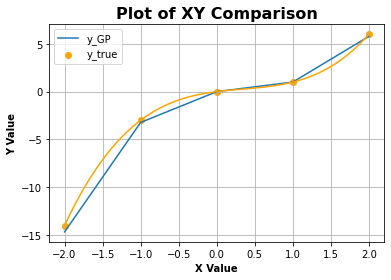

In [9]:
q_y = 3
y_GP_input = np.zeros((n,3))
for j in range(n):
    y_GP_input[j] = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]])

y_GP_Opt = create_y_data(q_y,y_GP_input)

title = "XY Comparison"
plot_xy(Xexp, Yexp, y_GP_Opt,Theta_True,title)